# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [82]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline

In [83]:
plt.rcParams.update(
        {
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'font.size': 12,
            'figure.dpi': 72.0,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.size': 5.0,
            'xtick.minor.size': 2.5,
            'ytick.major.size': 5.0,
            'ytick.minor.size': 2.5,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'axes.grid': True,
            'axes.titlesize': 'larger',
            'axes.labelsize': 'larger',
            'grid.color': 'dimgray',
            'grid.linestyle': '-',
            'grid.alpha': 0.3,
            'axes.prop_cycle': cycler(
                color=[
                    '#0C5DA5',
                    '#FF9500',
                    '#00B945',
                    '#FF2C00',
                    '#845B97',
                    '#474747',
                    '#9E9E9E',
                ]
            ) * cycler(alpha=[0.8]),
            'scatter.marker': 'x',
            'lines.linewidth': 1.0,
        })

In [84]:
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

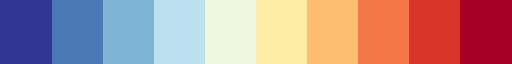

In [85]:
#define centered colorbar
emb = ListedColormap(mpl.colormaps['RdYlBu_r'](np.linspace(0, 1, 10)))
emb

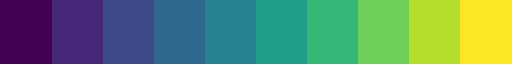

In [86]:
#define progressive colorbar
myvir = ListedColormap(mpl.colormaps['viridis'](np.linspace(0, 1, 10)))
myvir

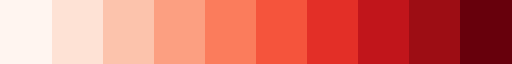

In [87]:
#define progressive colorbar
reds = ListedColormap(mpl.colormaps['Reds'](np.linspace(0, 1, 10)))
reds

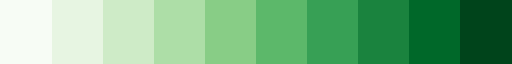

In [88]:
#define progressive colorbar
greens = ListedColormap(mpl.colormaps['Greens'](np.linspace(0, 1, 10)))
greens

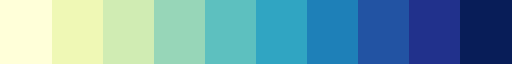

In [89]:
#define progressive colorbar
wet = ListedColormap(mpl.colormaps['YlGnBu'](np.linspace(0, 1, 10)))
wet

# Load files

LAM output analysis.

Simu irr et simu no-irr.

In [90]:
noirr_dir='../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../JZ_simu_outputs/LAM/irr_2010_2022'

In [91]:
#open netcdf files for native routing on ORC grid
# filename = '../../LAM/{}/SRF/MO/*history.nc'.format(noirr_dir)
# ORCnoirr0 = xr.open_mfdataset(filename)
# filename = '../../LAM/{}/SRF/MO/*history.nc'.format(irr_dir)
# ORCirr0 = xr.open_mfdataset(filename)
# ORCirr0

In [92]:
#open netcdf files for native routing diag_routing_r.nc (on MERIT grid)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(noirr_dir)
# DIAGRnoirr0 = xr.open_mfdataset(filename)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(irr_dir)
# DIAGRirr0 = xr.open_mfdataset(filename)
# DIAGRirr0

In [93]:
#open histmth files
filename = '{}/ATM/TS*.nc'.format(noirr_dir)
sim_noirr0 = xr.open_mfdataset(filename)

In [94]:
filename = '{}/ATM/TS*.nc'.format(irr_dir)
sim_irr0 = xr.open_mfdataset(filename)
sim_irr0

<xarray.Dataset>
Dimensions:            (time_counter: 156, bnds: 2, lon: 200, lat: 200)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
  * lon                (lon) float32 -13.0 -12.89 -12.79 ... 7.789 7.894 8.0
  * lat                (lat) float32 30.0 30.1 30.2 30.3 ... 49.7 49.8 49.9 50.0
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] dask.array<chunksize=(156, 2), meta=np.ndarray>
    evap               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    flat               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    precip             (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    sens               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t2m                (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         histmth
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2024-Apr-08 20:57:13 GMT
    uuid:         29e26a36-b630-44f8-a191-bf9e515af81c
    history:      Thu Jun 06 15:07:34 2024: cdo mergetime sim15_evap.nc sim13...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

# File manipulations

In [95]:
#rename time_counter to time all files
# ORCnoirr = ORCnoirr0.rename({'time_counter':'time'})
# ORCirr = ORCirr0.rename({'time_counter':'time'})
# DIAGRnoirr = DIAGRnoirr0.rename({'time_counter':'time'})
# DIAGRirr = DIAGRirr0.rename({'time_counter':'time'})
sim_noirr = sim_noirr0.rename({'time_counter':'time'})
sim_irr = sim_irr0.rename({'time_counter':'time'})

In [96]:
#Change dataset names attribute for automatic labeling
# ORCirr.attrs['name'] = 'ORC_irr'
# ORCnoirr.attrs['name'] = 'ORC_noirr'
# DIAGRirr.attrs['name'] = 'DIAGR_irr'
# DIAGRnoirr.attrs['name'] = 'DIAGR_noirr'
sim_irr.attrs['name'] = 'HISTMTH_irr'
sim_noirr.attrs['name'] = 'HISTMTH_noirr'

In [97]:
#Rename variables in natDIAG_R_month and natDIAG_R
# dict = {
#         'routing_stream_reservoir_r' : 'streamr',
#         'routing_fast_reservoir_r' : 'fastr',
#         'routing_slow_reservoir_r' : 'slowr',
#         'routing_drainage_r' : 'drainage',
#         'routing_runoff_r' : 'runoff',
#         'routing_hydrographs_r' : 'hydrographs',
#         # 'routing_irrigation_r' : 'irrigation',
#         # 'irrig_netereq_r' : 'netirrig'
#         # 'routing_riverflow_r' : 'riverflow',
#         # 'routing_coastalflow_r' : 'coastalflow'
#         }
#change the variables that exist according to the dictionary
# DIAGRnoirr = DIAGRnoirr.rename(dict)
# DIAGRirr = DIAGRirr.rename(dict)

In [98]:
#manually define irrig_deficit as netirrig-irrigation in ORC file
# ORCirr['irrig_deficit'] = ORCirr['netirrig'] - ORCirr['irrigation']
# #make irrig_deficit units mm/day
# ORCirr['irrig_deficit'].attrs['units'] = 'mm/day'
# # ORCirr
# ORCirr['irrig_frac'] = ORCirr['irrigmap_dyn']/ORCirr['Areas']
# sim_noirr['netrad']= sim_noirr['SWdnSFC']+sim_noirr['LWdnSFC'] - sim_noirr['SWupSFC'] - sim_noirr['LWupSFC']
# sim_irr['netrad']= sim_irr['SWdnSFC']+sim_irr['LWdnSFC'] - sim_irr['SWupSFC'] - sim_irr['LWupSFC']

In [99]:
# limit data to lon and lat of interest (-13,6) and (32,49)
# ORCirr = ORCirr.sel(lon=slice(-13,6),lat=slice(32,49))
# ORCnoirr = ORCnoirr.sel(lon=slice(-13,6),lat=slice(32,49))
sim_irr = sim_irr.sel(lon=slice(-13,6),lat=slice(32,49))
sim_noirr = sim_noirr.sel(lon=slice(-13,6),lat=slice(32,49))

In [100]:
# Select the JJA months (June, July, August)
# sim_irr = sim_irr.sel(time=sim_irr['time.month'].isin([6, 7, 8]))
# sim_noirr = sim_noirr.sel(time=sim_noirr['time.month'].isin([6, 7, 8]))

# Maps

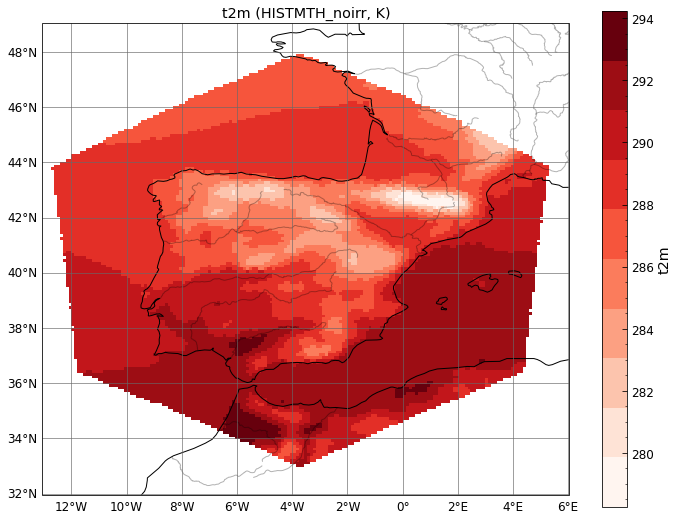

In [102]:
#Display map of var for ds
var='t2m'
ds=sim_noirr
color_map=reds
max_value=None
plotvar = ds[var].mean(dim='time') #*100 #*3600*24
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=color_map, vmax=max_value)
plt.title(var + ' ({}, {})' .format(ds.attrs['name'], ds[var].attrs['units']))
# plt.title('Applied irrigation (mm/day)')# ({})' .format(ds[var].attrs['units']))
plt.tight_layout()

Text(0.5, 1.0, 't2m difference (HISTMTH_irr - HISTMTH_noirr, K)')

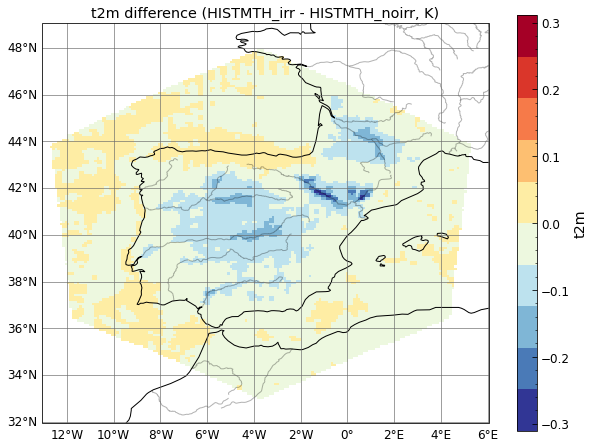

In [103]:
#Diff map
var='t2m'
max_value=None
ds1=sim_irr
ds2=sim_noirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') #* 3600 * 24
#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
plt.title(var + ' difference (' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
# plt.title('Transpiration difference (mm/day)')

In [ ]:
# Display 2 maps of var
var = 'plul'
maxvalue=2
color_map=reds

ds1 = sim_irr
ds2 = sim_noirr
plotvar_1 = ds1[var].mean(dim='time') #*3600*24
plotvar_2 = ds2[var].mean(dim='time') #*3600*24

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(var + ' ({})'.format(ds1[var].units))

# Plot for std dataset
axs[0].coastlines()
plotvar_1.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[0].set_title(f'{var} ({ds1.name})')

# Plot for natORC dataset
axs[1].coastlines()
plotvar_2.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[1].set_title(f'{var} ({ds2.name})')

In [ ]:
#Relative diff map
var='sfcWind'
maxvalue=None
ds1=sim_irr
ds2=sim_noirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time')
rel_diff = ((ds1[var]-ds2[var] + 1E-16) / (ds2[var] + 1E-16)).mean(dim='time') * 100
# Transform rel_diff using log10
rel_diff_log = np.log10(rel_diff)
#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
rel_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=maxvalue)
# rel_diff_log.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
plt.title(var + ' relative difference (' + ds1.name + ' - ' + ds2.name + '; %)')
# plt.title('Gross primary production relative difference (%)')

Text(0.5, 1.0, 't2m (HISTMTH_noirr)')

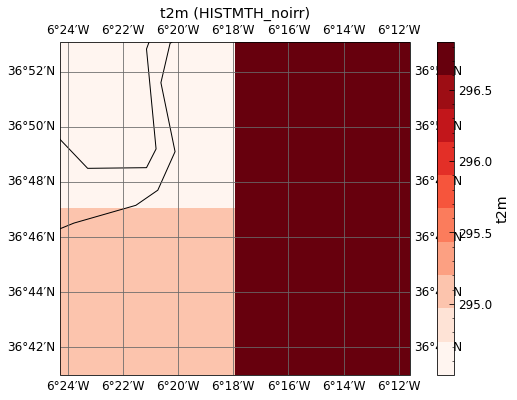

In [58]:
#Display map of var for ds on restricted area
var='t2m'
ds = sim_noirr
# ds = std
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
plt.title(var + ' (' + ds.name + ')')

In [ ]:
#Display map of var for ds averaged on a given year
var='hydrographs'
year=2012
ds = sim_noirr
# ds = ds.where(ds['time.year'] == year, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir)
plt.title(var + ' (' + ds.name + ')')

In [ ]:
# create map of wind as vector combining u and v components
ds = sim_irr
dist=6

#compute wind speed
wind_speed = (ds['u850'][0,:,:]**2 + ds['v850'][0,:,:]**2)**(1/2)
#extract x and y (u and v) components and reduce dimension
windx = ds['u850'][0,::dist,::dist]
windy = ds['v850'][0,::dist,::dist]
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
# wind_speed=(windx**2+windy**2)**(1/2)
# longi,lati=np.meshgrid(longi,lati)

#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
ax.quiver(longi, lati, windx, windy, transform=ccrs.PlateCarree(), scale=100)
plt.title('850hPa wind speed (m/s) and direction in Irr simulation')
plt.show()


In [ ]:
# wind difference
ds1 = sim_irr
ds2 = sim_noirr
dist=6

#compute wind speed
wind_speed1 = (ds1['u850'][0,:,:]**2 + ds1['v850'][0,:,:]**2)**(1/2)
wind_speed2 = (ds2['u850'][0,:,:]**2 + ds2['v850'][0,:,:]**2)**(1/2)
wind_speed_diff = wind_speed1 - wind_speed2
#extract x and y (u and v) components and reduce dimension
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
windx1 = ds1['u850'][0,::dist,::dist]
windy1 = ds1['v850'][0,::dist,::dist]
windx2 = ds2['u850'][0,::dist,::dist]
windy2 = ds2['v850'][0,::dist,::dist]
windx_diff = windx1 - windx2
windy_diff = windy1 - windy2


#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
ax.quiver(longi, lati, windx_diff, windy_diff, transform=ccrs.PlateCarree(), scale=10)
plt.title('850hPa wind speed (m/s) and direction difference')
plt.show()


# Time series

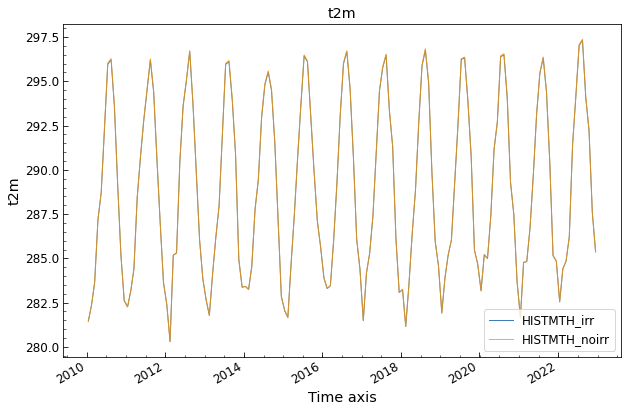

In [104]:
#Average time series
var='t2m'
ds1=sim_irr
ds2=sim_noirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()

In [ ]:
#Average seasonnal cycle
var='evap'
ds1=sim_irr
ds2=sim_noirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()